In [1]:
import os
import shutil
import zipfile
import subprocess

def download_fingerprint_dataset(kaggle_json_path='kaggle.json',
                                  dataset_name='peace1019/fingerprint-dataset-for-fvc2000-db4-b',
                                  target_dir='fingerprint_dataset'):
    # Step 1: Set up Kaggle API credentials
    os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
    shutil.copy(kaggle_json_path, os.path.expanduser('~/.kaggle/kaggle.json'))
    os.chmod(os.path.expanduser('~/.kaggle/kaggle.json'), 0o600)

    # Step 2: Download the dataset
    print("Downloading fingerprint dataset from Kaggle...")
    subprocess.run(['kaggle', 'datasets', 'download', '-d', dataset_name, '-p', target_dir], check=True)

    # Step 3: Unzip the dataset
    zip_name = 'fingerprint-dataset-for-fvc2000-db4-b.zip'
    zip_path = os.path.join(target_dir, zip_name)

    print("Unzipping dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(target_dir)

    extracted_path = os.path.join(target_dir, 'Fingerprint_Dataset')
    print(f"✅ Dataset extracted to: {extracted_path}")
    return extracted_path

download_fingerprint_dataset()

Unzipping dataset...
✅ Dataset extracted to: fingerprint_dataset/Fingerprint_Dataset


'fingerprint_dataset/Fingerprint_Dataset'

In [2]:
import zipfile
import os

def unzip_fingerprint_dataset(zip_path='/content/fingerprint_dataset/fingerprint-dataset-for-fvc2000-db4-b.zip',
                               extract_to='/content/fingerprint_dataset'):
    if os.path.exists(zip_path):
        print("Unzipping fingerprint dataset...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"✅ Dataset extracted to: {extract_to}")
    else:
        print(f"❌ Zip file not found at {zip_path}")

unzip_fingerprint_dataset()


Unzipping fingerprint dataset...
✅ Dataset extracted to: /content/fingerprint_dataset


In [3]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import random
# Imports
import os
import numpy as np
import random
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [4]:
IMG_SIZE = 128
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATASET_PATH = "fingerprint_dataset/dataset_FVC2000_DB4_B/dataset/train_data"

In [5]:
def load_images_and_labels(data_dir):
    image_paths = []
    labels = []
    for file in sorted(os.listdir(data_dir)):
        if file.endswith('.bmp'):
            label = file.split('_')[0]
            path = os.path.join(data_dir, file)
            image_paths.append(path)
            labels.append(label)
    return image_paths, labels

def load_image(path):
    image = Image.open(path).convert('L').resize((IMG_SIZE, IMG_SIZE))
    image = np.array(image)
    image = np.stack([image]*3, axis=-1)  # Convert grayscale to RGB
    image = image.astype(np.float32) / 255.0
    return image

# Load and preprocess images
image_paths, labels = load_images_and_labels(DATASET_PATH)
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
images = np.array([load_image(p) for p in image_paths])
labels = np.array(encoded_labels)


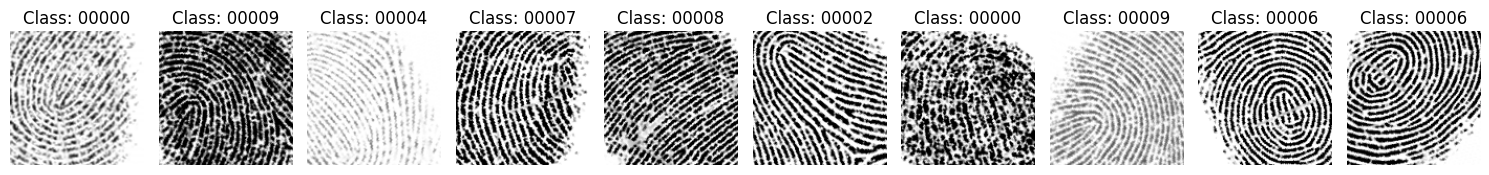

In [6]:
import matplotlib.pyplot as plt
import random

def show_sample_images(images, labels, label_encoder, n=10):
    plt.figure(figsize=(15, 5))
    indices = random.sample(range(len(images)), n)
    for i, idx in enumerate(indices):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[idx].squeeze(), cmap='gray')
        plt.title(f"Class: {label_encoder.inverse_transform([labels[idx]])[0]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_sample_images(images, labels, label_encoder, n=10)


In [7]:
print(images.shape)
print(labels.shape)

(800, 128, 128, 3)
(800,)


In [8]:

# Create support, query, and siamese training sets
def create_support_query_siamese_train_sets(images, labels, n_classes=5, n_shots=5):
    unique_classes = np.unique(labels)
    selected_classes = random.sample(list(unique_classes), n_classes)

    support_images, support_labels = [], []
    query_images, query_labels = [], []

    query_distribution = [5,5,5,5,5]  # Adjust for your number of classes

    for idx, class_id in enumerate(selected_classes):
        class_indices = np.where(labels == class_id)[0]
        support_idx = random.sample(list(class_indices), n_shots)
        support_images.extend(images[support_idx])
        support_labels.extend([class_id]*n_shots)

        remaining_idx = [i for i in class_indices if i not in support_idx]
        query_idx = random.sample(remaining_idx, query_distribution[idx])
        query_images.extend(images[query_idx])
        query_labels.extend([class_id]*len(query_idx))

    # Remove all examples belonging to selected_classes from Siamese train set
    mask = ~np.isin(labels, selected_classes)
    siamese_train_images = images[mask]
    siamese_train_labels = labels[mask]

    return (np.array(support_images), np.array(support_labels),
            np.array(query_images), np.array(query_labels),
            np.array(siamese_train_images), np.array(siamese_train_labels))


support_images, support_labels, query_images, query_labels, siamese_train_images, siamese_train_labels = create_support_query_siamese_train_sets(images, labels)


In [9]:
import numpy as np

print("*************************")

print("Support Set images shape:", support_images.shape)
print("Support Set labels shape:", support_labels.shape)

print("*************************")

print("Query Set images shape:", query_images.shape)
print("Query Set labels shape:", query_labels.shape)

print("Query Set unique labels:", np.unique(query_labels))

print("*************************")

print("Siamese Train images shape:", siamese_train_images.shape)
print("Siamese Train labels shape:", siamese_train_labels.shape)

print("Siamese Train unique labels:", np.unique(siamese_train_labels))

print("*************************")


*************************
Support Set images shape: (25, 128, 128, 3)
Support Set labels shape: (25,)
*************************
Query Set images shape: (25, 128, 128, 3)
Query Set labels shape: (25,)
Query Set unique labels: [1 2 5 6 8]
*************************
Siamese Train images shape: (400, 128, 128, 3)
Siamese Train labels shape: (400,)
Siamese Train unique labels: [0 3 4 7 9]
*************************


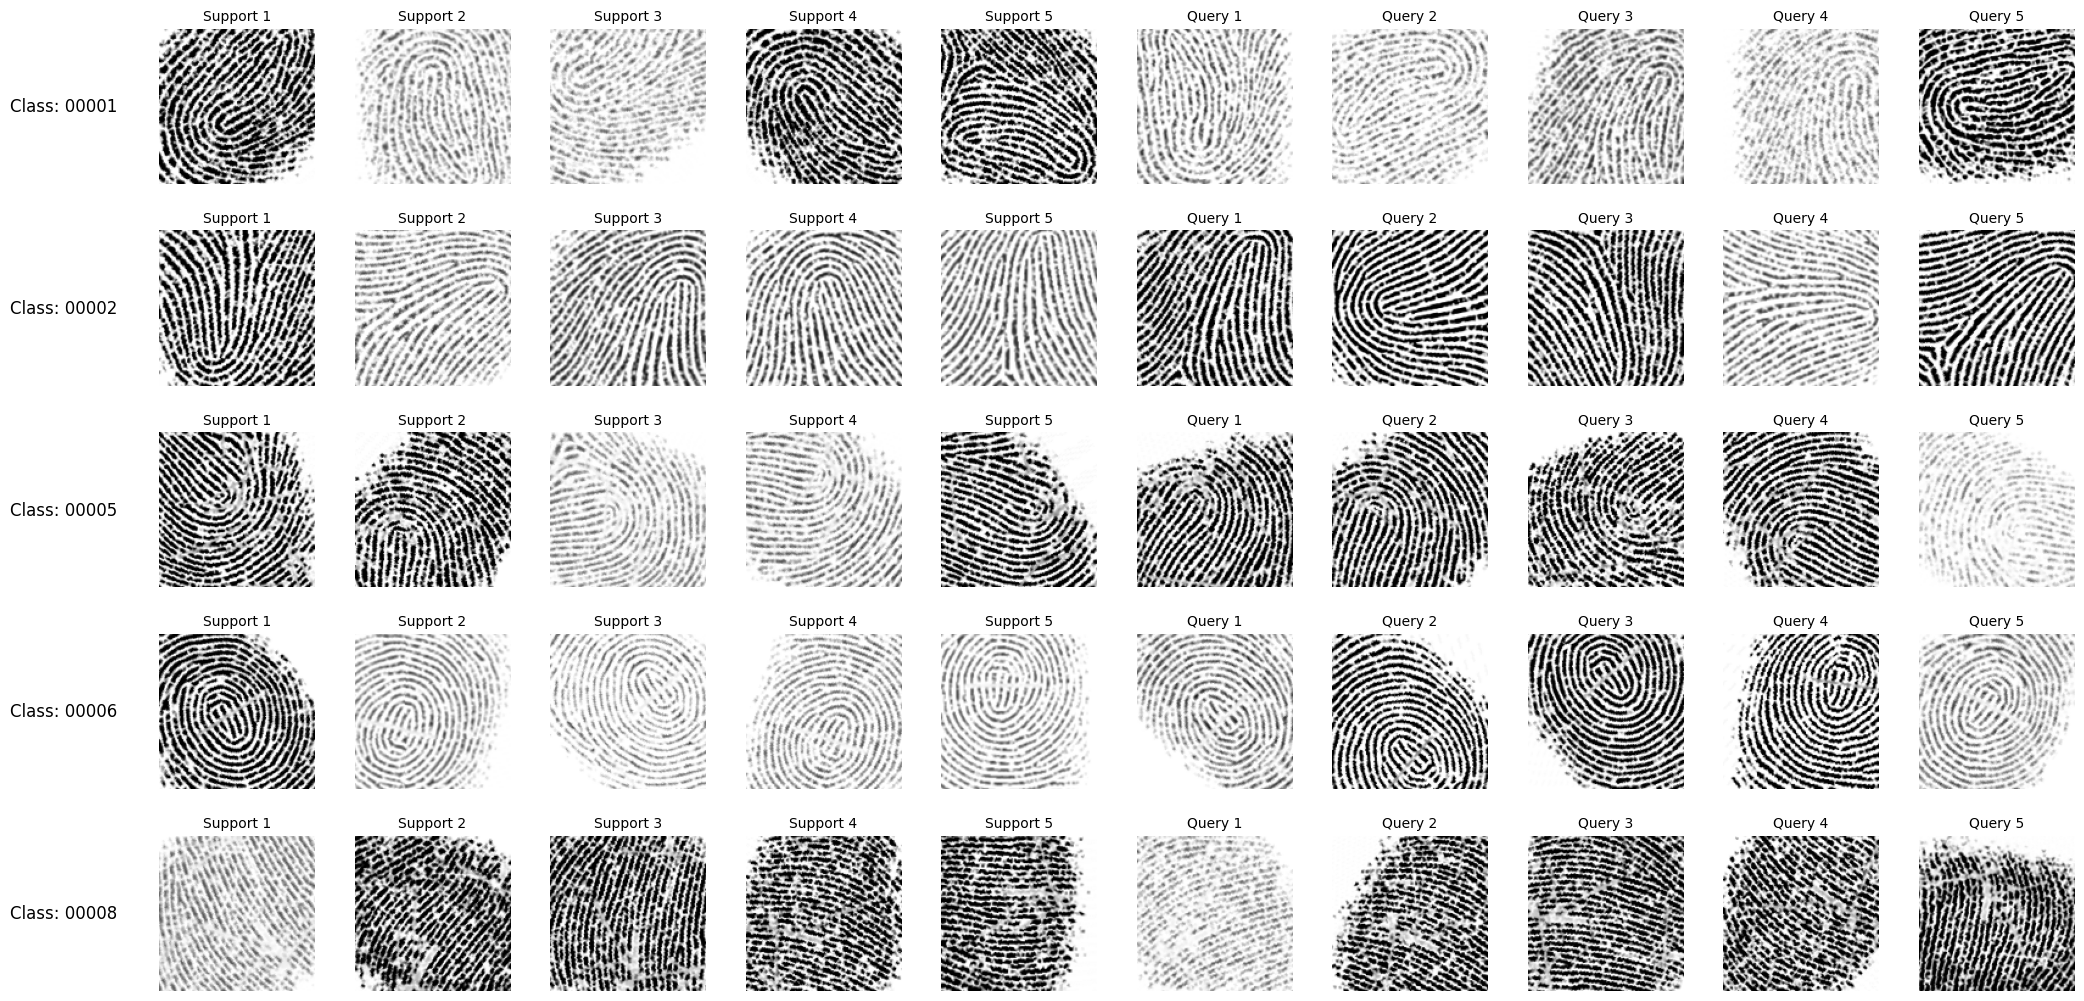

In [10]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

def visualize_support_query_sets(support_images, support_labels, query_images, query_labels, class_names_dict):
    unique_classes = np.unique(support_labels)
    num_classes = len(unique_classes)
    num_support = 5
    num_query = 5
    num_cols = num_support + num_query

    fig, axes = plt.subplots(num_classes, num_cols, figsize=(num_cols * 2.5, num_classes * 2.5))

    if num_classes == 1:
        axes = np.expand_dims(axes, axis=0)

    def preprocess_image(image):
        if image.max() <= 1:
            image = (image * 255).astype(np.uint8)
        return image

    for row_idx, class_id in enumerate(unique_classes):
        class_name = class_names_dict[class_id]

        # Get support and query images for the class
        support_idxs = np.where(support_labels == class_id)[0]
        query_idxs = np.where(query_labels == class_id)[0]
        support_imgs = support_images[support_idxs]
        query_imgs = query_images[query_idxs]

        # Display support images
        for i in range(num_support):
            ax = axes[row_idx, i]
            if i < len(support_imgs):
                img = preprocess_image(support_imgs[i])
                ax.imshow(img, cmap='gray')
                ax.set_title(f"Support {i+1}", fontsize=10)
            else:
                ax.set_title("Empty")
            ax.axis("off")

        # Display query images
        for j in range(num_query):
            ax = axes[row_idx, j + num_support]
            if j < len(query_imgs):
                img = preprocess_image(query_imgs[j])
                ax.imshow(img, cmap='gray')
                ax.set_title(f"Query {j+1}", fontsize=10)
            else:
                ax.set_title("Empty")
            ax.axis("off")

        # عنوان کلاس در کنار ردیف
        ax_row = axes[row_idx, 0]
        ax_row.annotate(f"Class: {class_name}", xy=(0, 0.5), xycoords="axes fraction",
                        fontsize=12, ha="right", va="center", xytext=(-30, 0), textcoords="offset points")

    plt.subplots_adjust(wspace=0.1, hspace=0.3)
    plt.show()


class_names_dict = {i: name for i, name in enumerate(label_encoder.classes_)}
visualize_support_query_sets(support_images, support_labels, query_images, query_labels, class_names_dict)



In [11]:
def create_triplet_pairs_from_siamese_train(siamese_train_images, siamese_train_labels):
    anchor_images = []
    positive_images = []
    negative_images = []

    # Generate triplet pairs
    for i in range(len(siamese_train_images)):
        anchor_img = siamese_train_images[i]
        anchor_label = siamese_train_labels[i]

        positive_idx = np.random.choice(np.where(siamese_train_labels == anchor_label)[0])
        positive_img = siamese_train_images[positive_idx]

        negative_label = np.random.choice([label for label in np.unique(siamese_train_labels) if label != anchor_label])
        negative_idx = np.random.choice(np.where(siamese_train_labels == negative_label)[0])
        negative_img = siamese_train_images[negative_idx]

        anchor_images.append(anchor_img)
        positive_images.append(positive_img)
        negative_images.append(negative_img)

    # Convert lists to numpy arrays
    anchor_images = np.array(anchor_images)
    positive_images = np.array(positive_images)
    negative_images = np.array(negative_images)

    # Print statistics
    print(f"Total triplets: {len(anchor_images)}")
    print(f"Anchor images shape: {anchor_images.shape}")
    print(f"Positive images shape: {positive_images.shape}")
    print(f"Negative images shape: {negative_images.shape}")

    return anchor_images, positive_images, negative_images


# Example usage
anchor_images, positive_images, negative_images = create_triplet_pairs_from_siamese_train(siamese_train_images, siamese_train_labels)


Total triplets: 400
Anchor images shape: (400, 128, 128, 3)
Positive images shape: (400, 128, 128, 3)
Negative images shape: (400, 128, 128, 3)


In [12]:
from tensorflow.keras.applications import EfficientNetB0

def build_feature_extractor():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Lambda(lambda t: tf.math.l2_normalize(t, axis=1))(x)  # Unit vector
    return models.Model(base_model.input, x)



model = build_feature_extractor()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
def triple_loss(y_true, y_pred, margin=0.1):
    positive_distance = y_pred[:, 0]
    negative_distance = y_pred[:, 1]
    loss = tf.maximum(positive_distance - negative_distance + margin, 0)
    return tf.reduce_mean(loss)

# Euclidean distance function
def triplet_distance(vectors):
    tensor_1, tensor_2 = vectors
    distance = tf.sqrt(tf.reduce_sum(tf.square(tensor_1 - tensor_2), axis=-1, keepdims=True) + 1e-7)
    distance = tf.clip_by_value(distance, 1e-7, 1e7)
    return distance


# Mean Squared Error (MSE) metric
def mse_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Build the Siamese model with Triple Loss
def build_siamese_model_with_triple_loss():
    feature_extractor = build_feature_extractor()

    input_a = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    input_b = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    input_c = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    feat_a = feature_extractor(input_a)
    feat_b = feature_extractor(input_b)
    feat_c = feature_extractor(input_c)

    # Calculate the positive and negative distances using triplet_distance
    positive_distance = layers.Lambda(triplet_distance, output_shape=(1,))([feat_a, feat_b])
    negative_distance = layers.Lambda(triplet_distance, output_shape=(1,))([feat_a, feat_c])

    distances = layers.Concatenate(axis=-1)([positive_distance, negative_distance])

    # Create the Siamese model
    siamese_network = models.Model(inputs=[input_a, input_b, input_c], outputs=distances)

    # Compile the model with Adam optimizer and triple loss
    siamese_network.compile(optimizer=Adam(learning_rate=0.0001), loss=triple_loss, metrics=[mse_metric])

    return siamese_network

# Build and compile the Siamese model with Triple Loss
siamese_model = build_siamese_model_with_triple_loss()

# Display the model summary
siamese_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 256)       │  4,377,507 │ input_layer_2[0]… │
│ (Functional)        │                   │            │ input_layer_3[0]… │
│                     │                   │            │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 1)         │          0 │ functional_1[0][… │
│                     │                   │            │ functional_1[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 1)         │          0 │ functional_1[0][… │
│                     │                   │            │ functional_1[2][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2)         │          0 │ lambda_2[0][0],   │
│ (Concatenate)       │                   │            │ lambda_3[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,377,507 (16.70 MB)

 Trainable params: 4,335,484 (16.54 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [14]:
# Split the triplets into training and validation sets
train_anchor, validation_anchor, train_positive, validation_positive, train_negative, validation_negative = train_test_split(
    anchor_images, positive_images, negative_images, test_size=0.2, random_state=42
)


dummy_train_labels = np.zeros((train_anchor.shape[0], 1))
dummy_validation_labels = np.zeros((validation_anchor.shape[0], 1))


siamese_model.fit(
    [train_anchor, train_positive, train_negative],
    dummy_train_labels,
    epochs=30,
    batch_size=32,
    validation_data=(
        [validation_anchor, validation_positive, validation_negative],
        dummy_validation_labels
    )
)

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - loss: 0.0760 - mse_metric: 1.2287 - val_loss: 0.1140 - val_mse_metric: 0.0331
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 57s 150ms/step - loss: 0.0478 - mse_metric: 1.2211 - val_loss: 0.0933 - val_mse_metric: 0.0134
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 0.0264 - mse_metric: 1.2132 - val_loss: 0.0861 - val_mse_metric: 0.0096
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - loss: 0.0117 - mse_metric: 1.2029 - val_loss: 0.0916 - val_mse_metric: 0.0570
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - loss: 0.0080 - mse_metric: 1.2046 - val_loss: 0.1030 - val_mse_metric: 0.0927
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - loss: 0.0088 - mse_metric: 1.1983 - val_loss: 0.0799 - val_mse_metric: 0.0784
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - loss: 0.0053 - mse_metric: 1.1903 - val_loss: 0.0804 - val_mse_metric: 0.0991
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - loss: 0.0033 - mse_met

In [ ]:
# Display model summary
siamese_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_2        │ (None, 256)       │  4,377,507 │ input_layer_6[0]… │
│ (Functional)        │                   │            │ input_layer_7[0]… │
│                     │                   │            │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 1)         │          0 │ functional_2[0][… │
│                     │                   │            │ functional_2[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 1)         │          0 │ functional_2[0][… │
│                     │                   │            │ functional_2[2][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2)         │          0 │ lambda_3[0][0],   │
│ (Concatenate)       │                   │            │ lambda_4[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,048,477 (49.78 MB)

 Trainable params: 4,335,484 (16.54 MB)

 Non-trainable params: 42,023 (164.16 KB)

 Optimizer params: 8,670,970 (33.08 MB)

In [ ]:
siamese_model.save('siamese_model.h5')

In [15]:
def create_triplets_from_support_pairs(support_images, support_labels):
    anchor_images = []
    positive_images = []
    negative_images = []


    for i in range(len(support_images)):
        anchor_img = support_images[i]
        anchor_label = support_labels[i]


        positive_indices = np.where(support_labels == anchor_label)[0]
        positive_indices = positive_indices[positive_indices != i]
        positive_idx = np.random.choice(positive_indices)
        positive_img = support_images[positive_idx]


        negative_label = np.random.choice([label for label in np.unique(support_labels) if label != anchor_label])
        negative_indices = np.where(support_labels == negative_label)[0]
        negative_idx = np.random.choice(negative_indices)
        negative_img = support_images[negative_idx]

        anchor_images.append(anchor_img)
        positive_images.append(positive_img)
        negative_images.append(negative_img)

    return np.array(anchor_images), np.array(positive_images), np.array(negative_images)

anchor_images, positive_images, negative_images = create_triplets_from_support_pairs(support_images, support_labels)

print(f"Anchor images shape: {anchor_images.shape}")
print(f"Positive images shape: {positive_images.shape}")
print(f"Negative images shape: {negative_images.shape}")

Anchor images shape: (25, 128, 128, 3)
Positive images shape: (25, 128, 128, 3)
Negative images shape: (25, 128, 128, 3)


In [16]:
dummy_labels = np.zeros((anchor_images.shape[0], 2))

siamese_model.fit(
    [anchor_images, positive_images, negative_images],
    dummy_labels,
    epochs=30,
    batch_size=32
)

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 101s 101s/step - loss: 0.0445 - mse_metric: 1.2161
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.0189 - mse_metric: 1.2131
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 8.4060e-04 - mse_metric: 1.2306
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.0110 - mse_metric: 1.1980
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0100 - mse_metric: 1.2119
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0000e+00 - mse_metric: 1.1955
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0000e+00 - mse_metric: 1.1906
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0000e+00 - mse_metric: 1.1748
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 7.1797e-04 - mse_metric: 1.1948
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.0000e+00 - mse_metric: 1.1951
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.0010 - mse_metric: 1.2081
Epoch 12/30
1/1 ━━━━━━━━━━━

In [17]:
import time

def predict_query_class_triplet_with_timing(model, support_images, support_labels, query_images, query_labels):
    predictions = []
    times = []

    dummy_neg = np.zeros_like(support_images[0])  # Use dummy negative for inference

    for i, query_img in enumerate(query_images):
        min_distance = float("inf")
        best_class = None

        start_time = time.time()  # Start timing this query

        for j, support_img in enumerate(support_images):
            distances = model.predict([
                np.expand_dims(query_img, axis=0),
                np.expand_dims(support_img, axis=0),
                np.expand_dims(dummy_neg, axis=0)
            ], verbose=0)

            pos_distance = distances[0][0]

            if pos_distance < min_distance:
                min_distance = pos_distance
                best_class = support_labels[j]

        end_time = time.time()  # End timing

        inference_time = end_time - start_time
        times.append(inference_time)
        predictions.append(best_class)

        print(f"Query {i+1}/{len(query_images)} took {inference_time:.4f} seconds")

    avg_time = sum(times) / len(times)
    print(f"\nAverage inference time per query: {avg_time:.4f} seconds")

    return predictions, times


In [19]:
predictions, inference_times = predict_query_class_triplet_with_timing(
    model=siamese_model,
    support_images=support_images,
    support_labels=support_labels,
    query_images=query_images,
    query_labels=query_labels
)

Query 1/25 took 2.9105 seconds
Query 2/25 took 2.5143 seconds
Query 3/25 took 2.5938 seconds
Query 4/25 took 2.3405 seconds
Query 5/25 took 2.5256 seconds
Query 6/25 took 2.3250 seconds
Query 7/25 took 2.7609 seconds
Query 8/25 took 2.5227 seconds
Query 9/25 took 2.1782 seconds
Query 10/25 took 2.2043 seconds
Query 11/25 took 2.2025 seconds
Query 12/25 took 2.7505 seconds
Query 13/25 took 2.4145 seconds
Query 14/25 took 2.3871 seconds
Query 15/25 took 2.3444 seconds
Query 16/25 took 2.2406 seconds
Query 17/25 took 2.7033 seconds
Query 18/25 took 2.5184 seconds
Query 19/25 took 2.0955 seconds
Query 20/25 took 2.2907 seconds
Query 21/25 took 2.3137 seconds
Query 22/25 took 2.7732 seconds
Query 23/25 took 2.4585 seconds
Query 24/25 took 2.1914 seconds
Query 25/25 took 2.6237 seconds

Average inference time per query: 2.4473 seconds


In [ ]:
def predict_query_class_triplet(model, support_images, support_labels, query_images, query_labels):
    predictions = []

    dummy_neg = np.zeros_like(support_images[0])  # Use dummy negative for inference

    for i, query_img in enumerate(query_images):
        min_distance = float("inf")
        best_class = None

        for j, support_img in enumerate(support_images):
            # Predict using (anchor=query, positive=support, negative=dummy)
            distances = model.predict([
                np.expand_dims(query_img, axis=0),
                np.expand_dims(support_img, axis=0),
                np.expand_dims(dummy_neg, axis=0)
            ], verbose=0)

            pos_distance = distances[0][0]  # The model returns [pos_dist, neg_dist]

            if pos_distance < min_distance:
                min_distance = pos_distance
                best_class = support_labels[j]

        predictions.append(best_class)

    return predictions


In [ ]:
predicted_classes = predict_query_class_triplet(
    siamese_model, support_images, support_labels, query_images, query_labels
)


correct_count = 0
total_queries = len(query_images)

print("\nQuery Predictions:\n")
for i, (pred, true_class) in enumerate(zip(predicted_classes, query_labels)):
    is_correct = "Correct" if pred == true_class else "Wrong"
    if pred == true_class:
        correct_count += 1
    print(f"Query {i+1}: True Class = {true_class}, Predicted Class = {pred} --> {is_correct}")

accuracy = (correct_count / total_queries) * 100
print(f"\n Classification Accuracy: {accuracy:.2f}%")


Query Predictions:

Query 1: True Class = 9, Predicted Class = 9 --> Correct
Query 2: True Class = 9, Predicted Class = 9 --> Correct
Query 3: True Class = 9, Predicted Class = 4 --> Wrong
Query 4: True Class = 9, Predicted Class = 9 --> Correct
Query 5: True Class = 9, Predicted Class = 0 --> Wrong
Query 6: True Class = 1, Predicted Class = 9 --> Wrong
Query 7: True Class = 1, Predicted Class = 1 --> Correct
Query 8: True Class = 1, Predicted Class = 4 --> Wrong
Query 9: True Class = 1, Predicted Class = 1 --> Correct
Query 10: True Class = 1, Predicted Class = 9 --> Wrong
Query 11: True Class = 0, Predicted Class = 0 --> Correct
Query 12: True Class = 0, Predicted Class = 1 --> Wrong
Query 13: True Class = 0, Predicted Class = 1 --> Wrong
Query 14: True Class = 0, Predicted Class = 0 --> Correct
Query 15: True Class = 0, Predicted Class = 0 --> Correct
Query 16: True Class = 2, Predicted Class = 0 --> Wrong
Query 17: True Class = 2, Predicted Class = 2 --> Correct
Query 18: True Cla

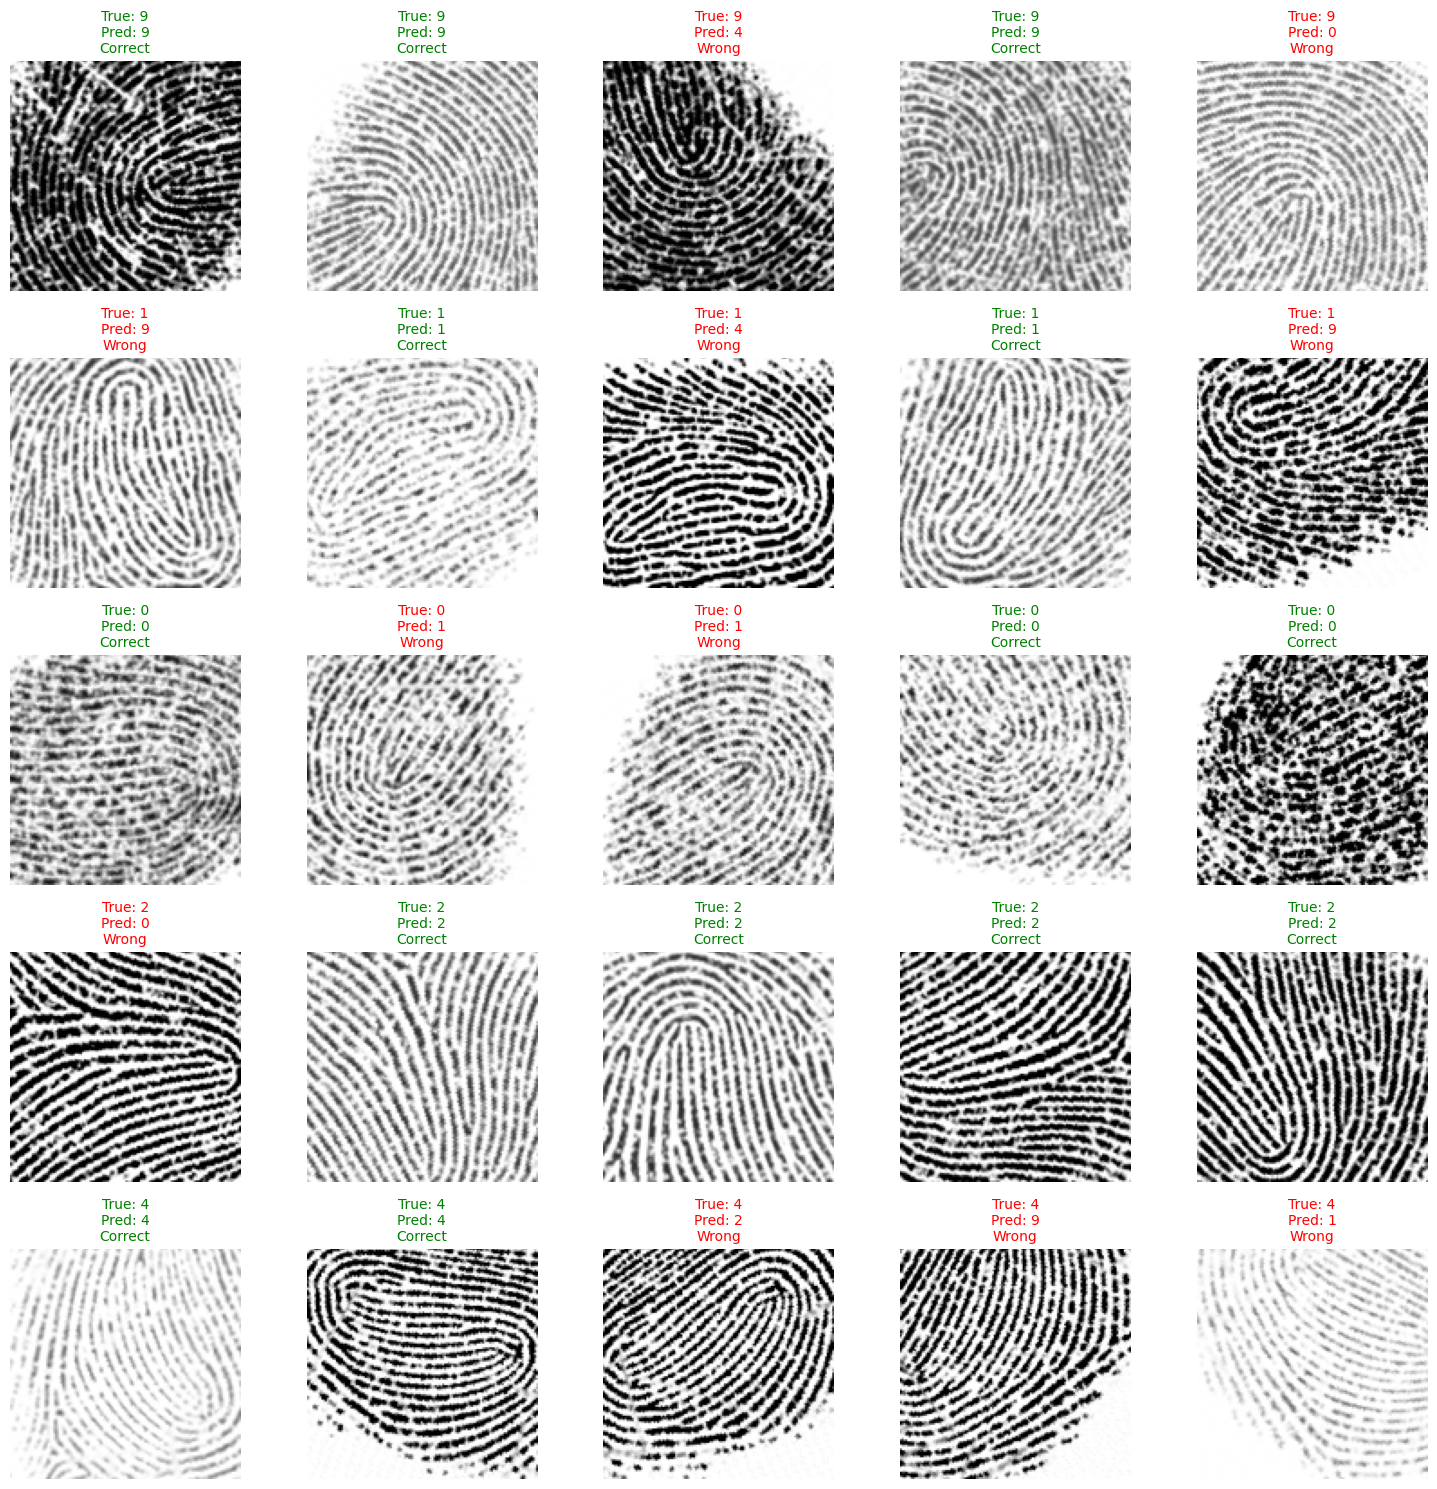

In [ ]:
import math
import matplotlib.pyplot as plt

def display_all_query_predictions(query_images, query_labels, predicted_classes, images_per_row=5):
    num_samples = len(query_images)
    num_rows = math.ceil(num_samples / images_per_row)

    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(images_per_row * 3, num_rows * 3))

    # Flatten axes for easy indexing
    axes = axes.flatten()

    for i in range(len(query_images)):
        axes[i].imshow(query_images[i])
        axes[i].axis('off')

        true_class = query_labels[i]
        predicted_class = predicted_classes[i]

        if true_class == predicted_class:
            title_color = "green"
            result_text = "Correct"
        else:
            title_color = "red"
            result_text = "Wrong"

        axes[i].set_title(f"True: {true_class}\nPred: {predicted_class}\n{result_text}",
                          color=title_color, fontsize=10)

    # Hide remaining empty axes if any
    for i in range(num_samples, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Usage
display_all_query_predictions(query_images, query_labels, predicted_classes)
